# Problem 1: Segmentation


In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torch.utils import data
from torchvision import transforms as T
from torchvision import models

# from google.colab import drive
# drive.mount('/content/drive')

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
import gc
gc.collect()

import torch
torch.cuda.empty_cache()

In [ ]:
!gdown https://drive.google.com/uc?id=1eYYJ26R1S9Ln_ExwHFBqd3rbln9qVdi4&export=download
!unzip -qq cityscapes.zip

Downloading...
From (original): https://drive.google.com/uc?id=1eYYJ26R1S9Ln_ExwHFBqd3rbln9qVdi4
From (redirected): https://drive.google.com/uc?id=1eYYJ26R1S9Ln_ExwHFBqd3rbln9qVdi4&confirm=t&uuid=052cbcaa-f748-4035-aa01-8895abb6a15d
To: /content/cityscapes.zip
100% 651M/651M [00:10<00:00, 60.5MB/s]


In [ ]:
class Segmenter(torch.nn.Module):
    def __init__(self, n_classes, encoder):
        super(Segmenter, self).__init__()
        self.encoder = encoder

        self.decoder = nn.Sequential(
        nn.Conv2d(256, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, n_classes, kernel_size=3, padding=1)
    )

    def forward(self, x):
      # print("X shape:", x.shape)
      x = self.encoder(x)
      x = self.decoder(x)
      return x

In [ ]:
class CityScapesDataset(Dataset):
  def __init__(self, images, labels, im_transform, mask_transform):
    self.images = images
    self.labels = labels
    self.im_transform = im_transform
    self.mask_transform = mask_transform

  def __getitem__(self, idx):
    im = Image.open(self.images[idx])
    mask = Image.open(self.labels[idx])
    im = self.im_transform(im)[0:3, ...] # Transform image

    # Add an extra first dimension to mask (needed for transforms), convert
    # to LongTensor b/c values are integers, and apply transforms.
    mask = np.asarray(mask)[None, ...]
    mask = torch.LongTensor(mask)
    mask = self.mask_transform(mask)

    # Apply random horizontal flip to image and mask
    if np.random.rand() > 0.5:
      im = TF.hflip(im)
      mask  = TF.hflip(mask)

    # im = im.clone().detach()
    # mask = mask.clone().detach()

    return im, mask

  def __len__(self):
    return len(self.images)

In [ ]:
batch_size = 16

# Make image and mask transforms.
im_transform = [T.ToTensor()]
im_transform.append(T.Resize((256, 256), interpolation=T.InterpolationMode.BILINEAR))
im_transform = T.Compose(im_transform)

mask_transform = T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST)

def get_dataloader(im_path):
  images = sorted(glob.glob(im_path + '/*8bit.jpg'))
  labels = sorted(glob.glob(im_path + '/*labelIds.png'))
  dataset = CityScapesDataset(images, labels, im_transform, mask_transform)
  return data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Create dataloaders
train_dataloader = get_dataloader('./cityscapes/train')
val_dataloader = get_dataloader('./cityscapes/val')

In [ ]:
# Get features from VGG16 up through 3 downsampling (maxpool) operations.
vgg = models.vgg16(pretrained=True);
encoder = nn.Sequential(*(list(vgg.children())[:1])[0][0:17]);

# Create model
n_classes = 34
model = Segmenter(n_classes, encoder);
model.to('cuda');

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 138MB/s]


In [ ]:
lr = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 7 # change back to 7

# Problem 1b: Your training loop code goes here


for epoch in range(num_epochs):

  model.train()

  for batch, (X, y) in enumerate(train_dataloader):

    torch.cuda.empty_cache()

    print(f"X shape: {X.shape}")

    if torch.cuda.is_available():
      X = X.to('cuda').float()
      y = y.to('cuda')

    N, C, H, W = X.shape

    y = torch.reshape(y, (N, H, W))

    pred = model.forward(X)

    # print("pred shape: ", pred.shape)
    # print("y shape: ", y.shape)
    loss = loss_fn(pred, y)



    optimizer.zero_grad()


    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      print("Epoch #", epoch, "; batch #", batch, "; train loss: ", loss.item(), sep='')

  model.eval()

  avg_val_loss = 0

  for batch, (X, y) in enumerate(val_dataloader):

    torch.cuda.empty_cache()

    if torch.cuda.is_available():
      X = X.to('cuda').float()
      y = y.to('cuda')

    N, C, H, W = X.shape

    y = torch.reshape(y, (N, H, W))

    with torch.no_grad():
      pred = model.forward(X)
      val_loss = loss_fn(pred, y)

      avg_val_loss += val_loss

  avg_val_loss /= len(val_dataloader)

  print("Epoch #", epoch, "; val_loss: ", avg_val_loss.item(), sep='')

  torch.save(model.state_dict(), 'model_%d.params' % epoch)



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


X shape: torch.Size([16, 3, 256, 256])
Epoch #0; batch #0; train loss: 0.6255396008491516
X shape: torch.Size([16, 3, 256, 256])


KeyboardInterrupt: 

In [ ]:
# Problem 1c: Your IoU evaluation code goes here

# Reload model from params
model.load_state_dict(torch.load('./model_6.params'))
model.eval()




images = sorted(glob.glob('./cityscapes/val' + '/*8bit.jpg'))
labels = sorted(glob.glob('./cityscapes/val' + '/*labelIds.png'))
val_dataset = CityScapesDataset(images, labels, im_transform, mask_transform)


for class_ in range(n_classes):

  avg_iou = 0

  for img_idx in range(val_dataset.__len__()):

    im, mask = val_dataset.__getitem__(img_idx)

    X = im.to('cuda')



    X = X.reshape((1, 3, 256, 256))

    # print(f"X shape: {X.shape}")

    mask = mask.reshape((256, 256)) == class_

    # print(mask)
    # print(f"mask shape: {mask.shape}")

    with torch.no_grad():
      pred = model.forward(X).to('cpu')


    pred = pred.reshape((34, 256, 256)).argmax(dim=0) == class_

    # print(f"pred shape: {pred.shape}")
    # print(pred)

    mask = mask.numpy()
    pred = pred.numpy()

    intersection = np.logical_and(mask, pred)
    union = np.logical_or(mask, pred)
    iou_score = np.sum(intersection) / np.sum(union)


    if not np.isnan(iou_score):
      avg_iou += iou_score

  avg_iou /= val_dataset.__len__()

  print(f"Average IoU for class{class_}: {avg_iou}")




<ipython-input-26-bb062e64e61b>:50: RuntimeWarning: invalid value encountered in scalar divide
  iou_score = np.sum(intersection) / np.sum(union)


Average IoU for class0: 0.0
Average IoU for class1: 0.8710208540165039
Average IoU for class2: 0.42831884455297875
Average IoU for class3: 0.8020118789921
Average IoU for class4: 0.0030573796375653814
Average IoU for class5: 0.0
Average IoU for class6: 0.00042494465057326563
Average IoU for class7: 0.8699788644105805
Average IoU for class8: 0.44644223162552593
Average IoU for class9: 0.008850766750671249
Average IoU for class10: 0.0
Average IoU for class11: 0.6339493071324948
Average IoU for class12: 0.008012873616994117
Average IoU for class13: 0.025196017266583052
Average IoU for class14: 0.0
Average IoU for class15: 1.0130246020260492e-05
Average IoU for class16: 0.0
Average IoU for class17: 0.046543275230409804
Average IoU for class18: 0.0
Average IoU for class19: 0.009868278626056793
Average IoU for class20: 0.10229519455655081
Average IoU for class21: 0.7107795561822042
Average IoU for class22: 0.10075277951167058
Average IoU for class23: 0.6161625906969693
Average IoU for class2

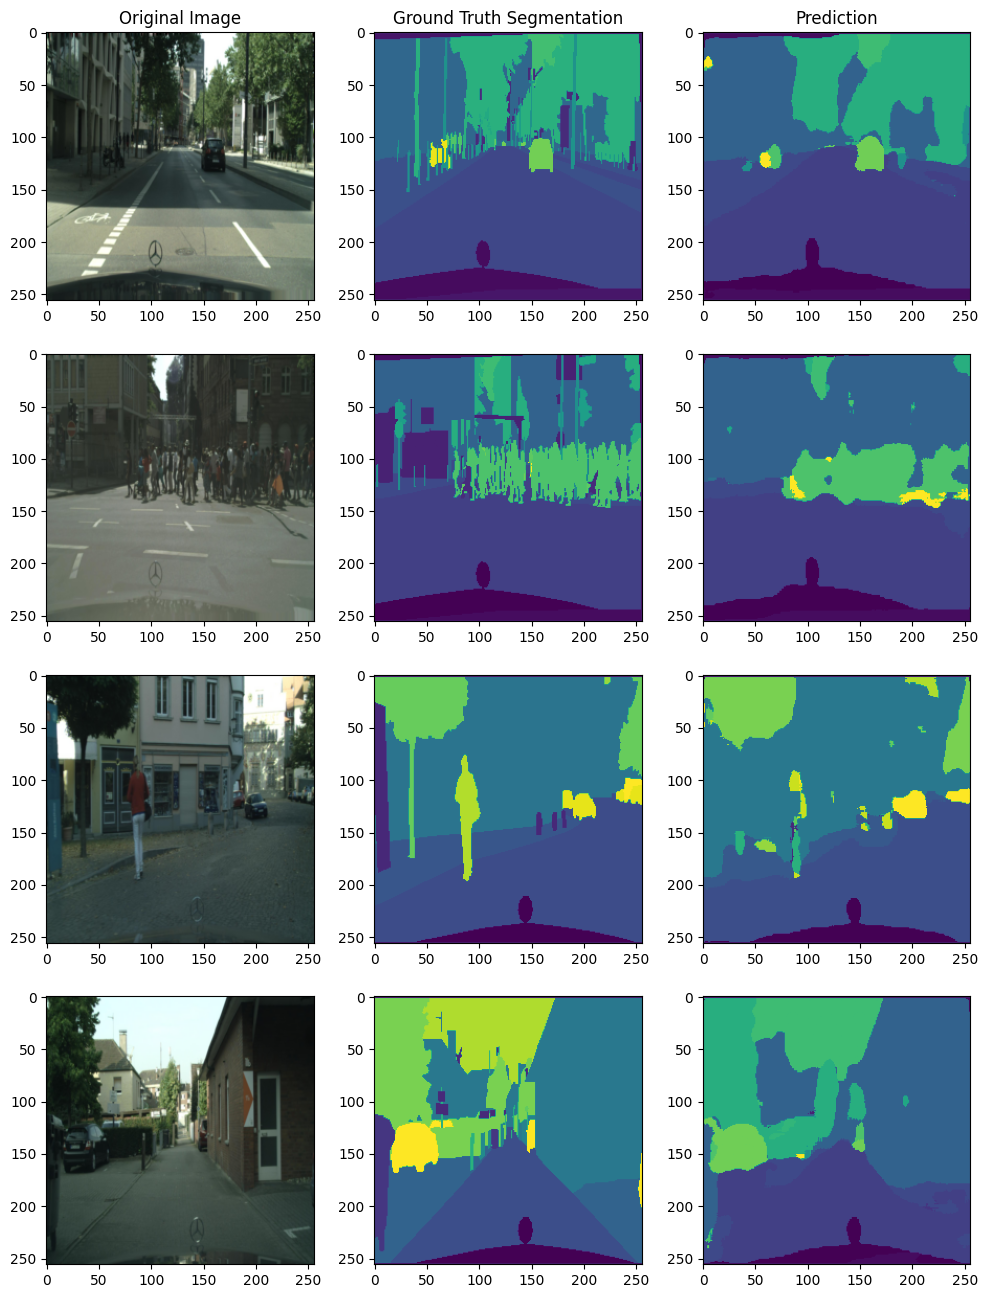

In [ ]:
# Problem 1d: Your image results code goes here

fig, axs = plt.subplots(4, 3, figsize=(12, 16))

# frankfurt_000000_015389_leftImg8bit.jpg
im, mask = val_dataset.__getitem__(35)
X = im.to('cuda')
X = X.reshape((1, 3, 256, 256))
with torch.no_grad():
  pred = model.forward(X).to('cpu')
pred = pred.reshape((34, 256, 256)).argmax(dim=0)
axs[0, 2].imshow(pred)
im = np.einsum('CWH->WHC', im)
axs[0, 0].imshow(im)
mask = np.einsum('CWH->WHC', mask)
axs[0, 1].imshow(mask)


# frankfurt_000001_057954_leftImg8bit.jpg
im, mask = val_dataset.__getitem__(199)
X = im.to('cuda')
X = X.reshape((1, 3, 256, 256))
with torch.no_grad():
  pred = model.forward(X).to('cpu')
pred = pred.reshape((34, 256, 256)).argmax(dim=0)
axs[1, 2].imshow(pred)
im = np.einsum('CWH->WHC', im)
axs[1, 0].imshow(im)
mask = np.einsum('CWH->WHC', mask)
axs[1, 1].imshow(mask)


# lindau_000037_000019_leftImg8bit.jpg
im, mask = val_dataset.__getitem__(304)
X = im.to('cuda')
X = X.reshape((1, 3, 256, 256))
with torch.no_grad():
  pred = model.forward(X).to('cpu')
pred = pred.reshape((34, 256, 256)).argmax(dim=0)
axs[2, 2].imshow(pred)
im = np.einsum('CWH->WHC', im)
axs[2, 0].imshow(im)
mask = np.einsum('CWH->WHC', mask)
axs[2, 1].imshow(mask)


# munster_000173_000019_leftImg8bit.jpg
im, mask = val_dataset.__getitem__(499)
X = im.to('cuda')
X = X.reshape((1, 3, 256, 256))
with torch.no_grad():
  pred = model.forward(X).to('cpu')
pred = pred.reshape((34, 256, 256)).argmax(dim=0)
axs[3, 2].imshow(pred)
im = np.einsum('CWH->WHC', im)
axs[3, 0].imshow(im)
mask = np.einsum('CWH->WHC', mask)
axs[3, 1].imshow(mask)

axs[0,0].set_title('Original Image')
axs[0,1].set_title('Ground Truth Segmentation')
axs[0,2].set_title('Prediction')

plt.savefig('four_images.png', dpi=600)


In [ ]:
!ls -l /content/cityscapes/val > out.txt

# Problem 2: StyleGAN


In [ ]:
# setup correct PyTorch version
!pip install -U torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
import torch

# Download the code
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

# install other dependencies
!pip install ninja

print('PyTorch version: {}'.format(torch.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(torch.cuda.get_device_name()))

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.1+cu110 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [ ]:
# Download the model
import argparse
import numpy as np
import PIL.Image
import dnnlib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio
import matplotlib.pyplot as plt
import legacy
import cv2
import torch
from tqdm.autonotebook import tqdm

device = torch.device('cuda')

# Choose between these pretrained models
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqcat.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqdog.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqwild.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/brecahad.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"

# If downloads fails, you can try downloading manually and uploading to the session directly
# network_pkl = "/content/ffhq.pkl"

print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as f:
  G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...


In [ ]:
# Useful utility functions...

# Generates an image from a style vector.
def generate_image_from_style(dlatent, noise_mode='none'):

  if len(dlatent.shape) == 1:
    dlatent = dlatent.unsqueeze(0)

  row_images = G.synthesis(dlatent, noise_mode=noise_mode)
  row_images = (row_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return row_images[0].cpu().numpy()

# Converts a noise vector z to a style vector w.
def convert_z_to_w(latent, truncation_psi=0.7, truncation_cutoff=9, class_idx=None):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
    if class_idx is None:
      RuntimeError('Must specify class label with class_idx when using a conditional network')
    label[:, class_idx] = 1
  else:
    if class_idx is not None:
      print(f'warning: class_idx={class_idx} ignored when running on an unconditional network')
  return G.mapping(latent, label, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


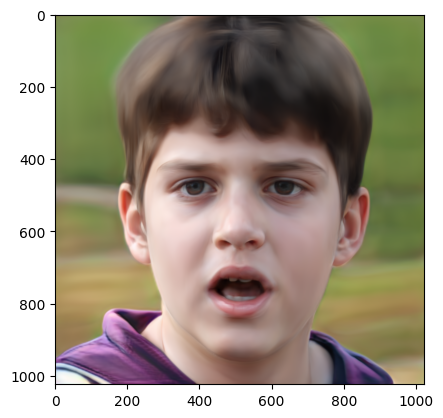

In [ ]:
# Sample code to generate images.
np.random.seed(123) # You can change this random seed.

# Generate a random noise (z) vector.
z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device)

# Convert z vector to w vector.
w = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9)

# Generate and show image.
img = generate_image_from_style(w)
plt.imshow(img)

## LATENT SPACE FACE TRAVERSALS

In [ ]:
# download
!gdown "1vekENF84yvVpKhMaChqTVEyttAckZ4PU" -O "../"

Downloading...
From (original): https://drive.google.com/uc?id=1vekENF84yvVpKhMaChqTVEyttAckZ4PU
From (redirected): https://drive.google.com/uc?id=1vekENF84yvVpKhMaChqTVEyttAckZ4PU&confirm=t&uuid=860cbdbd-36b1-4879-aaeb-cd856c7f54d2
To: /content/ffhq-Gender.weights
100% 94.4M/94.4M [00:00<00:00, 248MB/s]


In [ ]:
from torchvision import models as tv
cnn = tv.resnet50(pretrained=False, progress=True, num_classes = 1)
cnn.eval()
cnn.load_state_dict(torch.load('../ffhq-Gender.weights', map_location=lambda storage, loc: storage))

# Returns whether face is perceptually female (True) or male (False) given
# an input image of shape (H, W, 3).
def face_is_female(img):
  im = np.asarray(img)/255.0
  im = cv2.resize(im, (256, 256))
  im = np.expand_dims(np.transpose(im, (2,0,1)), 0)
  im = torch.FloatTensor(im)
  logits = cnn(im)[0, 0]
  return (logits < 0.5).numpy()

Problem 1a: Interpolation between two faces and gender classification.


Image 0 is female.
Image 1 is male.


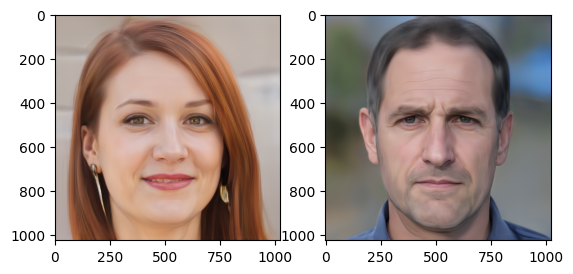

In [ ]:
# Your code goes here.

# Your code goes here.

fig, axs = plt.subplots(1,2)

np.random.seed(0)
z0 = torch.from_numpy(np.random.randn(1, 512)).to(device)
w0 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)
img0 = generate_image_from_style(w0)
axs[0].imshow(img0)

np.random.seed(1)
z1 = torch.from_numpy(np.random.randn(1, 512)).to(device)
w1 = convert_z_to_w(z1, truncation_psi=0.7, truncation_cutoff=9)
img1 = generate_image_from_style(w1)
axs[1].imshow(img1)

for i, img in enumerate([img0, img1]):
  gender = "female" if face_is_female(img) else "male"
  print(f"Image {i} is {gender}.")



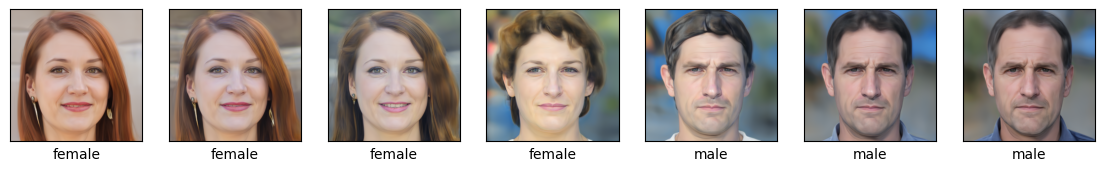

In [ ]:
def interpolate(p1, p2, num_steps):
    # Ensure both points have the same dimensionality
    assert len(p1) == len(p2)

    # Generate intermediate points
    intermediates = []
    for i in range(num_steps + 1):
        alpha = i / num_steps
        intermediate_point = (1 - alpha) * p1 + alpha * p2
        intermediates.append(intermediate_point)

    return intermediates


interpolated_points = interpolate(z0, z1, num_steps=6)

fig, axs = plt.subplots(1,7, figsize=(14, 4))

for i, point in enumerate(interpolated_points):
  w = convert_z_to_w(point, truncation_psi=0.7, truncation_cutoff=9)
  img = generate_image_from_style(w)

  axs[i].imshow(img)

  gender = "female" if face_is_female(img) else "male"
  axs[i].set_xlabel(gender)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

plt.savefig('seven_between_zs.png', dpi=600)


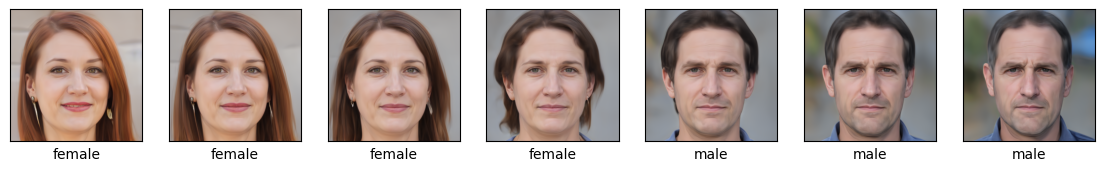

In [ ]:
w0 = convert_z_to_w(z0, truncation_psi=0.7, truncation_cutoff=9)
w1 = convert_z_to_w(z1, truncation_psi=0.7, truncation_cutoff=9)

interpolated_points = interpolate(w0, w1, num_steps=6)

fig, axs = plt.subplots(1,7, figsize=(14, 4))

for i, point in enumerate(interpolated_points):

  img = generate_image_from_style(point)

  axs[i].imshow(img)

  gender = "female" if face_is_female(img) else "male"
  axs[i].set_xlabel(gender)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

plt.savefig('seven_between_ws.png', dpi=600)

Problem 1b: Latent space traversals

In [ ]:
# Your code goes here.

zs = torch.from_numpy(np.random.randn(1000, 512)).to(device)
is_female_list = list()
ws = list()

for i in range(1000):
  w_i = convert_z_to_w(zs[i, :].reshape((1, 512)), truncation_psi=0.7, truncation_cutoff=9)
  ws.append(w_i)

  img = generate_image_from_style(w_i)
  is_female_list.append(face_is_female(img))

In [ ]:
new_ws = [w_i[:, 0, :].cpu().flatten() for w_i in ws]
X = np.stack(new_ws, axis=1).T

y = np.stack(is_female_list)

print(X.shape)
print(y.shape)

(1000, 512)
(1000,)


In [ ]:
from sklearn.svm import LinearSVC

clf = LinearSVC()

clf.fit(X, y)

LinearSVC()

In [ ]:
norm = clf.coef_

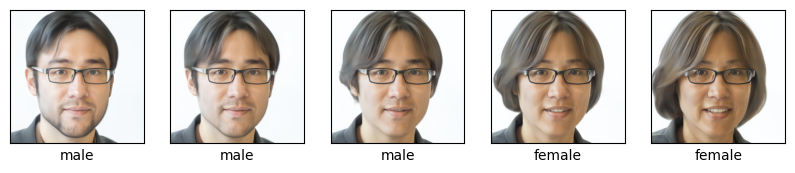

In [86]:
alpha = 0.25

fig, axs = plt.subplots(1,5, figsize=(10, 2))

np.random.seed(2)
z = torch.from_numpy(np.random.randn(1, 512)).to(device)
main = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9)


steps = [-2, -1, 0, 1, 2]
for i, step in enumerate(steps):

  img = generate_image_from_style(main + torch.from_numpy(step*alpha*norm).to('cuda'))

  gender = "female" if face_is_female(img) else "male"
  axs[i].imshow(img)
  axs[i].set_xlabel(gender)
  axs[i].set_xticks([])
  axs[i].set_yticks([])


plt.savefig('male_vs_female_1.png', dpi=600)

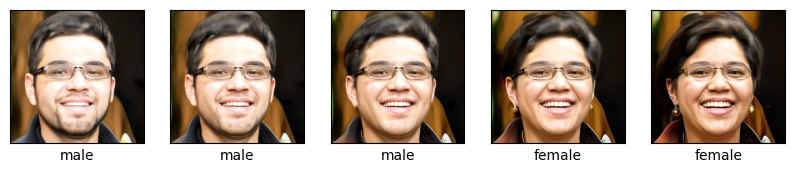

In [87]:
alpha = 0.25

fig, axs = plt.subplots(1,5, figsize=(10, 2))

np.random.seed(3)
z = torch.from_numpy(np.random.randn(1, 512)).to(device)
main = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9)


steps = [-2, -1, 0, 1, 2]
for i, step in enumerate(steps):

  img = generate_image_from_style(main + torch.from_numpy(step*alpha*norm).to('cuda'))

  gender = "female" if face_is_female(img) else "male"
  axs[i].imshow(img)
  axs[i].set_xlabel(gender)
  axs[i].set_xticks([])
  axs[i].set_yticks([])


plt.savefig('male_vs_female_2.png', dpi=600)

# Problem 3


In [ ]:
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7uzs4axg
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7uzs4axg
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [ ]:
import clip

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 122MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cifar = np.load('/content/drive/MyDrive/comp_546/hw_5/CIFAR(2).npz') # Replace with your path to CIFAR.
X,y,label_names = cifar['X'], cifar['y']*1.0, cifar['label_names']
print(label_names)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [ ]:
long_labels = [f"A picture of a {label}." for label in label_names]
long_labels[0] = 'A picture of an airplane.' # need to change article
long_labels[1] = 'A picture of an automobile.' # need to change article

print(long_labels)

['A picture of an airplane.', 'A picture of an automobile.', 'A picture of a bird.', 'A picture of a cat.', 'A picture of a deer.', 'A picture of a dog.', 'A picture of a frog.', 'A picture of a horse.', 'A picture of a ship.', 'A picture of a truck.']


In [ ]:
from tqdm import tqdm
captions = long_labels # Your code goes here.

preds = list()

# Iterate over all test examples.
for i in tqdm(range(50000, 60000)):
  image = preprocess(Image.fromarray(np.uint8(X[i,...]))).unsqueeze(0).to('cuda')
  text = clip.tokenize(captions).to('cuda')

  with torch.no_grad():
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # Your code goes here.
    preds.append(probs.argmax())

100%|██████████| 10000/10000 [03:33<00:00, 46.77it/s]


In [ ]:
# Your code goes here.
test_y = y[50000:60000]

overall_acc = sum(test_y == preds) / 10000

print(f"Overall accuracy: {100*overall_acc:.2f}%")

Overall accuracy: 88.15%


In [ ]:
# PART B

eng_labels = [f"A picture of a {label}, a photo of a {label}, a drawing of a {label}" for label in label_names]
eng_labels[0] = eng_labels[0].replace('f a ', 'f an ') # need to change article
eng_labels[1] = eng_labels[1].replace('f a ', 'f an ') # need to change article


print(eng_labels)

['A picture of an airplane, a photo of an airplane, a drawing of an airplane', 'A picture of an automobile, a photo of an automobile, a drawing of an automobile', 'A picture of a bird, a photo of a bird, a drawing of a bird', 'A picture of a cat, a photo of a cat, a drawing of a cat', 'A picture of a deer, a photo of a deer, a drawing of a deer', 'A picture of a dog, a photo of a dog, a drawing of a dog', 'A picture of a frog, a photo of a frog, a drawing of a frog', 'A picture of a horse, a photo of a horse, a drawing of a horse', 'A picture of a ship, a photo of a ship, a drawing of a ship', 'A picture of a truck, a photo of a truck, a drawing of a truck']


In [ ]:

captions = eng_labels # Your code goes here.

preds2 = list()

# Iterate over all test examples.
for i in tqdm(range(50000, 60000)):
  image = preprocess(Image.fromarray(np.uint8(X[i,...]))).unsqueeze(0).to('cuda')
  text = clip.tokenize(captions).to('cuda')

  with torch.no_grad():
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # Your code goes here.
    preds2.append(probs.argmax())

100%|██████████| 10000/10000 [03:35<00:00, 46.44it/s]


In [ ]:
# Your code goes here.
test_y = y[50000:60000]

overall_acc = sum(test_y == preds2) / 10000

print(f"Overall accuracy: {100*overall_acc:.2f}%")

Overall accuracy: 88.76%
